https://randerson112358.medium.com/stock-price-prediction-using-python-machine-learning-e82a039ac2bb

In [1]:
import math

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import tensorflow as tf

In [57]:
df= pd.read_csv('./data/AXP_2010-01-01_to_2020-01-01.csv')

In [58]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AXP,2010-01-04 00:00:00+00:00,40.92,41.10,40.39,40.81,6894300,34.658048,34.810503,34.209154,34.564881,6894300,0.00,1.0
1,AXP,2010-01-05 00:00:00+00:00,40.83,41.23,40.37,40.83,10641200,34.581821,34.920609,34.192214,34.581821,10641200,0.00,1.0
2,AXP,2010-01-06 00:00:00+00:00,41.49,41.67,41.17,41.23,8399400,35.140822,35.293276,34.869791,34.920609,8399400,0.00,1.0
3,AXP,2010-01-07 00:00:00+00:00,41.98,42.24,41.11,41.26,8981700,35.708292,35.929449,34.968268,35.095858,8981700,0.18,1.0
4,AXP,2010-01-08 00:00:00+00:00,41.95,42.48,41.40,41.76,7907700,35.682774,36.133593,35.214943,35.521159,7907700,0.00,1.0


In [59]:
df["date"] = pd.to_datetime(df["date"])


In [60]:
df.drop(columns=["symbol"], inplace=True)

In [61]:
df.set_index("date", inplace=True)

In [63]:
df=df[df.index<pd.Timestamp("2020-01-1 0:00:00", tz="Europe/Brussels")]
df.head()

,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
date,,,,,,,,,,,,
2010-01-04 00:00:00+00:00,40.92,41.10,40.39,40.81,6894300,34.658048,34.810503,34.209154,34.564881,6894300,0.00,1.0
2010-01-05 00:00:00+00:00,40.83,41.23,40.37,40.83,10641200,34.581821,34.920609,34.192214,34.581821,10641200,0.00,1.0
2010-01-06 00:00:00+00:00,41.49,41.67,41.17,41.23,8399400,35.140822,35.293276,34.869791,34.920609,8399400,0.00,1.0
2010-01-07 00:00:00+00:00,41.98,42.24,41.11,41.26,8981700,35.708292,35.929449,34.968268,35.095858,8981700,0.18,1.0
2010-01-08 00:00:00+00:00,41.95,42.48,41.40,41.76,7907700,35.682774,36.133593,35.214943,35.521159,7907700,0.00,1.0


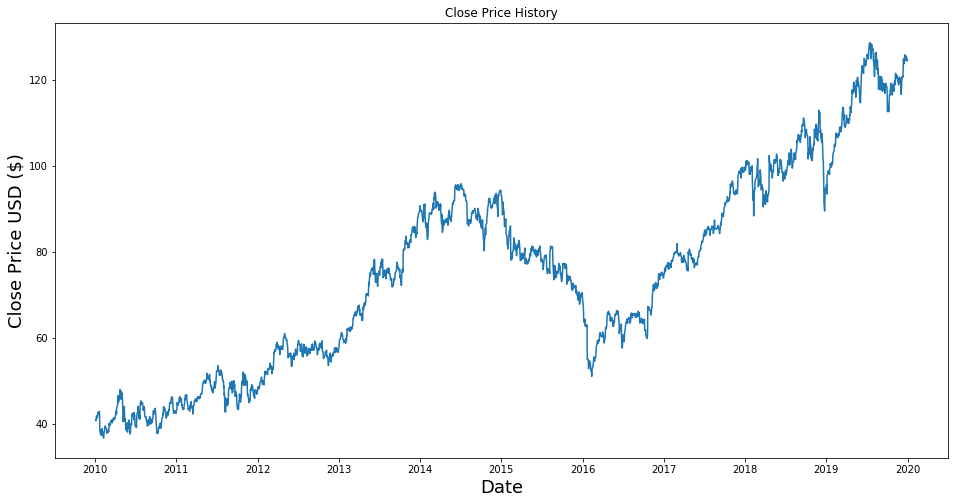

In [64]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [65]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['close'])
#Converting the dataframe to a numpy array
dataset = data.values
#Get /Compute the number of rows to train the model on
# training_data_len = math.ceil( len(dataset) *.8) 
training_data_len = len(df[df.index<=pd.Timestamp("2019-01-1 0:00:00", tz="Europe/Brussels")])


In [66]:
training_df=data[:training_data_len]


In [67]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0, 1)) 
scaled_data = scaler.fit_transform(dataset)

In [68]:
data["scaled_close"]=scaled_data


In [69]:
moving_avg = data.scaled_close.rolling(60, min_periods=60).mean()

In [70]:
exponential_moving_avg = data.scaled_close.ewm(alpha=0.1, adjust=False).mean()

In [71]:
cumulative_moving_avg = data.scaled_close.expanding().mean()

In [166]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
train_data_unscaled = dataset[0:training_data_len  , : ]

#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
y_train_simple = []

for i in range(60,len(train_data)):

    x_train.append(np.append(train_data[i-60:i,0], (moving_avg[i], exponential_moving_avg[i])))


    y_train.append(train_data[i,0])
    y_train_simple.append(np.sign(train_data_unscaled[i,0]- train_data_unscaled[i-1,0]))

In [167]:
#Convert x_train and y_train to numpy arrays
x_train, y_train, y_train_simple = np.array(x_train), np.array(y_train), np.array(y_train_simple)


In [168]:
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


In [169]:
x_train.shape


(2204, 62, 1)

In [188]:
import talos


def hyper(x_train, y_train,x_val, y_val, params):

    model = Sequential()
    model.add(LSTM(units=params['units_first_layer'], return_sequences=True,input_shape=(x_train.shape[1],1)))
    model.add(LSTM(units=params['units_first_layer'], return_sequences=False))
    model.add(Dense(units=params['units_second_layer']))
    model.add(Dropout(params['dropout']))
    model.add(Dense(units=1))
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)
    model.compile(optimizer=params['optimizer'], loss=['mean_squared_error'], metrics=[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None)])
    history = model.fit(x_train, y_train, epochs=4,batch_size=params['batch_size'], validation_data=(x_val, y_val),
                        shuffle=True,callbacks=[callback])


    return history, model

In [189]:

p = {
    'units_first_layer':[50, 100],
    'units_second_layer':[10,25],
    'dropout': [0, 0.3],
     'batch_size': [1, 10],
     'optimizer': [ 'Adam'],
#      'metric':[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None) ]
}

In [190]:

# p = {
#     'units_first_layer':[50],
#     'units_second_layer':[25],
#     'dropout': [0],
#      'batch_size': [1],
#     'epochs': [1],
#      'optimizer': ['Adam'],
#      'losses': ['mean_squared_error'],
#      'metric':[tf.keras.metrics.RootMeanSquaredError(name="root_mean_squared_error", dtype=None) ]
# }

In [203]:
type(y_train)

numpy.ndarray

In [200]:
# validation_split=math.ceil( len(x_train) *.6)
# t = talos.Scan(x=x_train[:validation_split], 
#                y=y_train[:validation_split],
#                x_val=x_train[validation_split:], 
#                y_val=y_train[validation_split:],
#                model=hyper,
#                params=p,
#                print_params=True,
#                experiment_name='stock')
t = talos.Scan(x=x_train,
               y=y_train,
               model=hyper,
               params=p,
               val_split=0.1,
               seed=1,
               print_params=True,
               experiment_name='stock')


  0%|          | 0/16 [00:00<?, ?it/s]

{'batch_size': 1, 'dropout': 0, 'optimizer': 'Adam', 'units_first_layer': 50, 'units_second_layer': 10}
Epoch 1/4


KeyboardInterrupt: 

In [192]:
analyze_object = talos.Analyze(t)
t.data[t.data.val_root_mean_squared_error==analyze_object.low('val_root_mean_squared_error')]

,start,end,duration,round_epochs,loss,root_mean_squared_error,val_loss,val_root_mean_squared_error,batch_size,dropout,optimizer,units_first_layer,units_second_layer
1,12/28/20-103350,12/28/20-103725,214.295071,4,0.000433,0.020816,0.000177,0.013292,1,0.0,Adam,50,25


In [194]:
analyze_object.low('val_root_mean_squared_error')


0.013291766867041588

In [ ]:
# #Build the LSTM network model
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
# model.add(LSTM(units=50, return_sequences=False))
# model.add(Dense(units=25))
# model.add(Dense(units=1))

# #Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# #Train the model
# model.fit(x_train, y_train, batch_size=1, epochs=1)

In [195]:
#Test data set
test_data = scaled_data[training_data_len - 60: , : ]
moving_avg_test= moving_avg[training_data_len-61:]
exponential_moving_avg_test= exponential_moving_avg[training_data_len-61:]
cumulative_moving_avg_test = cumulative_moving_avg[training_data_len-61:]

#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ]
y_test_simple = np.sign(y_test)
for i in range(60,len(test_data)):
    
    x_test.append(np.append(test_data[i-60:i,0],(moving_avg_test[i],exponential_moving_avg_test[i])))

    
#Convert x_test to a numpy array 
x_test = np.array(x_test)  

#Reshape the data into the shape accepted by the LSTM
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [182]:
# #Getting the models predicted price values
# predictions = model.predict(x_test) 
# predictions = scaler.inverse_transform(predictions)#Undo scaling

In [196]:
# predictions = t.best_model(metric='root_mean_squared_error', asc=True).predict(x_test) 
predictions = t.best_model(metric='val_root_mean_squared_error', asc=True).predict(x_test) 
predictions = scaler.inverse_transform(predictions)


In [136]:
from talos import Evaluate
e = Evaluate(t)

e.evaluate(x_test, y_test, task='continuous', metric='val_root_mean_squared_error',shuffle=False, asc=True)

[103.3346171274662,
 113.67538320746422,
 123.06681248335839,
 118.43398428254126,
 119.83422558050155]

In [138]:
t.evaluate_models(x_val = x_test, y_val = y_test, n_models=10, metric ='val_root_mean_squared_error',folds=5, shuffle=False,asc=True,task='continuous')


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]

>> Added evaluation score columns to scan_object.data


In [147]:
predictions = talos.Predict(t).predict(x_test,metric='val_root_mean_squared_error', asc=True)
predictions = scaler.inverse_transform(predictions)

In [197]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse



1.5309251005984954

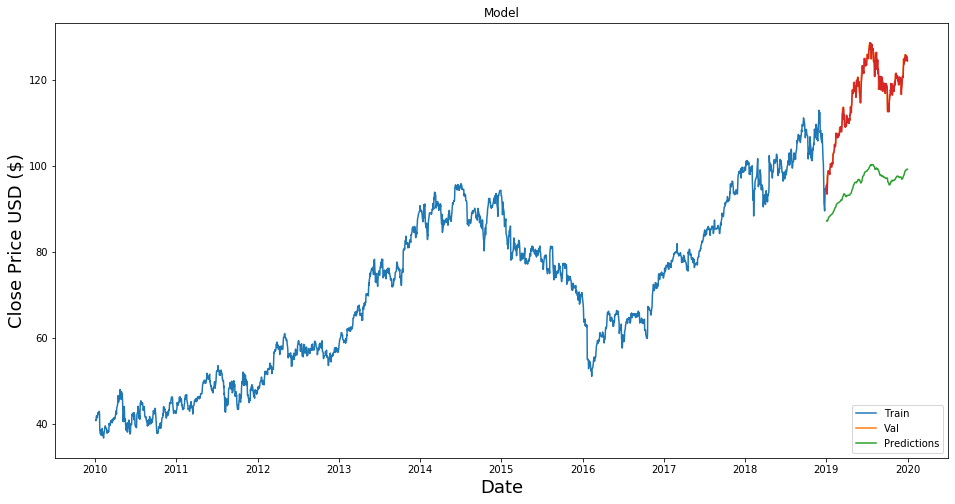

In [187]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
valid['test'] = scaler.inverse_transform(x_test[:,59])


#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['close'])
plt.plot(valid[['close', 'Predictions', 'test']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()